## 权重衰减
### 高维线性回归

In [1]:
%matplotlib inline
import torch
from torch import nn 
import sys
sys.path.append(r"/Users/kingsleycheng/Documents/github/UCAS/DeepLearning/mytorch/")
import mytorch


n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = mytorch.synthetic_data(true_w, true_b, num_inputs)
train_iter = mytorch.load_array(train_data, batch_size)
test_data = mytorch.synthetic_data(true_w, true_b, n_test)
test_iter = mytorch.load_array(test_data, batch_size, is_train=False)

### 从零开始实现
#### 初始化模型参数

In [2]:
def init_params():
    w = torch.normal(0,1, size = (num_inputs, 1),requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

#### 定义$L_2$范数惩罚

In [3]:
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

#### 定义训练代码实现

In [4]:
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: mytorch.linreg(X, w, b), mytorch.squared_loss
    num_epochs, lr = 100, 0.003
    animator = mytorch.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    
    for epoch in range(num_epochs):
        for X,y in train_iter:
            # 增加了L2范数惩罚项，
            # 广播机制使l2_penalty(w)成为一个长度为batch_size的向量
            l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            mytorch.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 ==0:
            animator.add(epoch + 1, (mytorch.evaluate_loss(net, train_iter, loss),
                                     mytorch.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数是：', torch.norm(w).item())

#### 忽略正则化直接训练

w的L2范数是： 4.5332441329956055


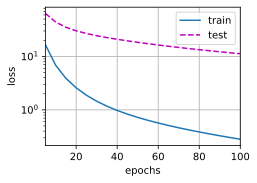

In [6]:
train(lambd=0)

#### 使用权重衰减

w的L2范数是： 0.03922370821237564


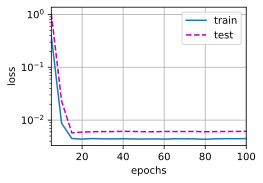

In [7]:
train(lambd=3)

### 简洁实现

In [10]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss(reduction="none")
    num_epochs, lr = 100, 0.003
    # 偏置参数没有衰减
    trainer = torch.optim.SGD([
        {'params': net[0].weight, 'weight_decay': wd},
        {'params': net[0].bias}], lr=lr)
    animator = mytorch.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.mean().backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1,
                         (mytorch.evaluate_loss(net, train_iter, loss),
                          mytorch.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数：', net[0].weight.norm().item())

w的L2范数： 4.434157371520996


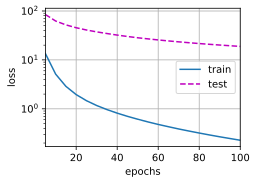

In [11]:
train_concise(0)

w的L2范数： 0.05894465744495392


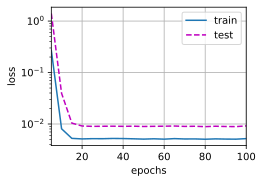

In [12]:
train_concise(3)